In [60]:
# ============================================================
# 🌪️ Week 7 – Stable Diffusion + Tiny LoRA (NOAA Hurricane Irma)
# ============================================================

!nvidia-smi
!pip install -q --upgrade torch torchvision torchaudio xformers \
    diffusers==0.32.1 transformers==4.45.2 huggingface_hub==0.25.2 \
    accelerate peft bitsandbytes safetensors pillow tqdm requests matplotlib

import os, requests, json, glob, torch, numpy as np
from pathlib import Path
from PIL import Image
from tqdm.auto import tqdm
from IPython.display import display

# --- GPU check ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"CUDA: {torch.version.cuda} | GPU: {torch.cuda.get_device_name(0)} | Torch: {torch.__version__}")

# --- Base paths ---
BASE = Path("/content/week7_noaa_lora")
for d in ["txt2img","img2img","inpaint","noaa_data","lora","lora_samples"]:
    (BASE/d).mkdir(parents=True, exist_ok=True)


Mon Oct 13 23:20:20 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             50W /  400W |    8119MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [17]:
import os, json, requests, pathlib
from getpass import getpass
from google.colab import files
import shutil

# --- Base setup ---
BASE = pathlib.Path(".")
(BASE / "noaa_data").mkdir(parents=True, exist_ok=True)

# --- NOAA API key (interactive for Colab) ---
if "NOAA_API_KEY" not in os.environ:
    NOAA_TOKEN = getpass("🔑 Enter your NOAA API key: ")
    os.environ["NOAA_API_KEY"] = NOAA_TOKEN
else:
    NOAA_TOKEN = os.environ["NOAA_API_KEY"]

# --- Validate token ---
if not NOAA_TOKEN or NOAA_TOKEN.strip() == "":
    raise ValueError("❌ NOAA API key not provided. Please rerun the cell and enter your token.")

# --- Request configuration (Hurricane Irma: Florida, Sept 5–15 2017) ---
endpoint = "https://www.ncdc.noaa.gov/cdo-web/api/v2/data"
params = {
    "datasetid": "GHCND",
    "locationid": "FIPS:12",  # Florida
    "startdate": "2017-09-05",
    "enddate": "2017-09-15",
    "limit": 10
}
headers = {"token": NOAA_TOKEN}

# --- Fetch NOAA metadata ---
try:
    resp = requests.get(endpoint, headers=headers, params=params)
    print(f"Status: {resp.status_code}")

    if resp.status_code == 200:
        (BASE / "noaa_raw.json").write_text(json.dumps(resp.json(), indent=2))
        print("✅ NOAA data saved to noaa_raw.json")

    elif resp.status_code in (401, 403):
        print("❌ Invalid or expired API key. Check https://www.ncdc.noaa.gov/cdo-web/token")

    else:
        print(f"⚠️ Unexpected status code {resp.status_code}: {resp.text[:200]}")

except requests.RequestException as e:
    print(f"🚫 Request failed: {e}")

# --- MANUAL IMAGE UPLOAD SECTION ---
print("\n📸 Upload your Hurricane Irma images (JPEG, PNG, etc.) from your computer:")
uploaded = files.upload()  # opens a file chooser in Colab

for fname in uploaded.keys():
    src = pathlib.Path(fname)
    dst = BASE / "noaa_data" / src.name
    shutil.move(str(src), dst)
    print(f"✅ Saved local image: {dst}")

print("\nAll uploaded images are now stored in:", BASE / "noaa_data")


Status: 200
✅ NOAA data saved to noaa_raw.json

📸 Upload your Hurricane Irma images (JPEG, PNG, etc.) from your computer:


Saving OIP.jpg to OIP.jpg
Saving NASA-and-NOAA-Satellites-capture-images-of-Hurricane-Irma-hitting-Florida-2.jpg to NASA-and-NOAA-Satellites-capture-images-of-Hurricane-Irma-hitting-Florida-2.jpg
Saving 53932.avif to 53932.avif
Saving 20170927-debris-filled-waterway-key-west-fl-1000.jpg to 20170927-debris-filled-waterway-key-west-fl-1000.jpg
✅ Saved local image: noaa_data/OIP.jpg
✅ Saved local image: noaa_data/NASA-and-NOAA-Satellites-capture-images-of-Hurricane-Irma-hitting-Florida-2.jpg
✅ Saved local image: noaa_data/53932.avif
✅ Saved local image: noaa_data/20170927-debris-filled-waterway-key-west-fl-1000.jpg

All uploaded images are now stored in: noaa_data


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .



Generating image 1: hurricane infographic showing Florida impact zones, clean infographic style


  0%|          | 0/5 [00:00<?, ?it/s]

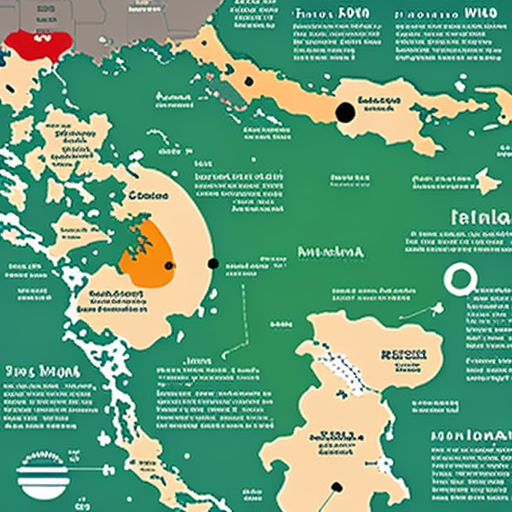

✅ Saved: txt2img/txt2img_01.png

Generating image 2: satellite view of hurricane swirling near Florida coast, labeled diagram


  0%|          | 0/5 [00:00<?, ?it/s]

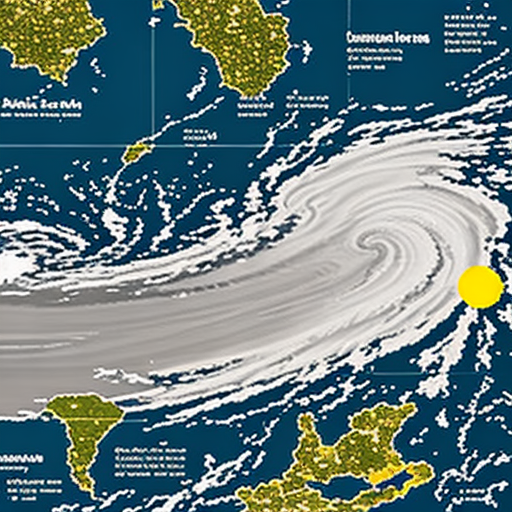

✅ Saved: txt2img/txt2img_02.png

Generating image 3: emergency response map showing hurricane paths and resource locations


  0%|          | 0/5 [00:00<?, ?it/s]

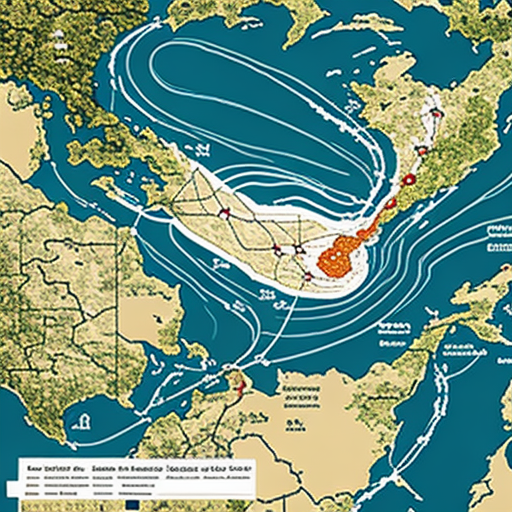

✅ Saved: txt2img/txt2img_03.png


In [19]:
import torch, pathlib
from diffusers import StableDiffusionPipeline
from IPython.display import display

# --- Base directory ---
BASE = pathlib.Path(".")
TXT2IMG_DIR = BASE / "txt2img"
TXT2IMG_DIR.mkdir(parents=True, exist_ok=True)  # <-- create folder if missing

# --- Load model (SD-Turbo) ---
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = StableDiffusionPipeline.from_pretrained(
    "stabilityai/sd-turbo",
    torch_dtype=torch.float16
).to(device)

# --- Prompts ---
prompts = [
    "hurricane infographic showing Florida impact zones, clean infographic style",
    "satellite view of hurricane swirling near Florida coast, labeled diagram",
    "emergency response map showing hurricane paths and resource locations"
]

# --- Generate images ---
for i, p in enumerate(prompts, 1):
    print(f"\nGenerating image {i}: {p}")
    img = pipe(p, num_inference_steps=5, guidance_scale=0.0).images[0]
    fp = TXT2IMG_DIR / f"txt2img_{i:02d}.png"
    img.save(fp)
    display(img)
    print(f"✅ Saved: {fp}")


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Using source image: txt2img/txt2img_02.png


  0%|          | 0/21 [00:00<?, ?it/s]

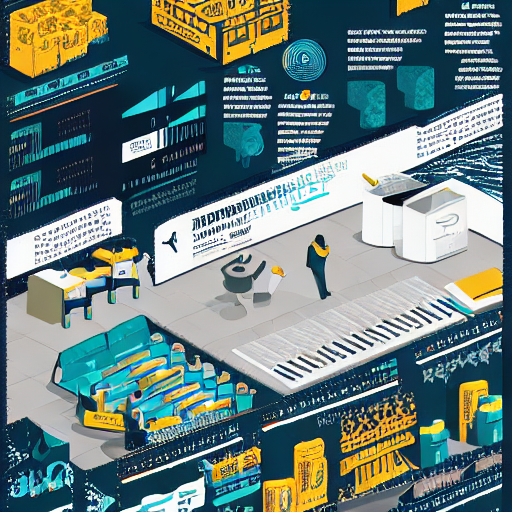

✅ Saved: img2img/example_i2i.png


In [20]:
import torch, pathlib
from diffusers import StableDiffusionImg2ImgPipeline
from PIL import Image
from IPython.display import display

# --- Base setup ---
BASE = pathlib.Path(".")
TXT2IMG_DIR = BASE / "txt2img"
IMG2IMG_DIR = BASE / "img2img"
IMG2IMG_DIR.mkdir(parents=True, exist_ok=True)  # <-- ensures the folder exists

device = "cuda" if torch.cuda.is_available() else "cpu"

# --- Load image-to-image pipeline ---
pipe_i2i = StableDiffusionImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16
).to(device)

# --- Select source image ---
# Use the first image generated from your text2img step
src_files = list(TXT2IMG_DIR.glob("*.png"))
if not src_files:
    raise FileNotFoundError(f"No source images found in {TXT2IMG_DIR}. Run the text2img step first.")

src = src_files[0]
print(f"Using source image: {src}")

# --- Prepare input image ---
init = Image.open(src).convert("RGB").resize((512, 512))

# --- Run img2img transformation ---
prompt = "vector-style redesign, crisp infographic aesthetic"
out = pipe_i2i(
    prompt=prompt,
    image=init,
    strength=0.7,
    guidance_scale=7.0,
    num_inference_steps=30
).images[0]

# --- Save output ---
fp = IMG2IMG_DIR / "example_i2i.png"
out.save(fp)
display(out)
print(f"✅ Saved: {fp}")


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/25 [00:00<?, ?it/s]

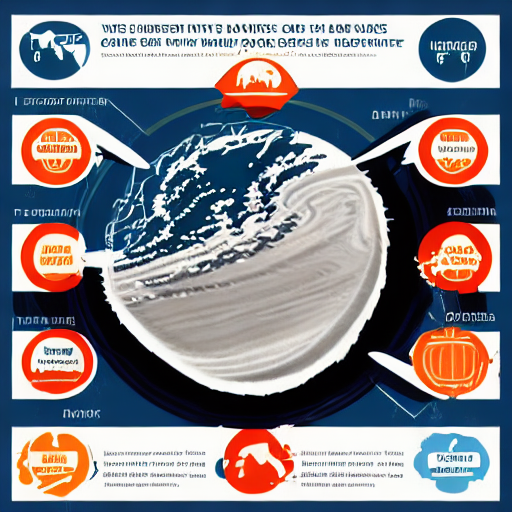

✅ Inpainted image saved to: inpaint/example_inpaint.png


In [21]:
import torch, pathlib, numpy as np
from diffusers import AutoPipelineForInpainting
from PIL import Image
from IPython.display import display

# --- Base setup ---
BASE = pathlib.Path(".")
INPAINT_DIR = BASE / "inpaint"
INPAINT_DIR.mkdir(parents=True, exist_ok=True)  # create folder

device = "cuda" if torch.cuda.is_available() else "cpu"

# --- Load inpainting pipeline ---
pipe_inp = AutoPipelineForInpainting.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    torch_dtype=torch.float16
).to(device)

# --- Ensure 'init' exists (from previous img2img step) ---
try:
    base_img = init
except NameError:
    raise RuntimeError("⚠️ Variable 'init' not found. Please run the img2img step first to define 'init'.")

# --- Create circular mask ---
mask = Image.new("L", (512, 512), 255)  # start with all white (keep)
Y, X = np.ogrid[:512, :512]
m = np.array(mask)
m[(X - 256)**2 + (Y - 256)**2 <= 100**2] = 0  # black circle in the center → area to inpaint
mask = Image.fromarray(m)

# --- Run inpainting ---
prompt = "insert hurricane symbol in center, flat infographic style"
res = pipe_inp(
    prompt=prompt,
    image=base_img,
    mask_image=mask,
    num_inference_steps=25
).images[0]

# --- Save output ---
fp = INPAINT_DIR / "example_inpaint.png"
res.save(fp)
display(res)
print(f"✅ Inpainted image saved to: {fp}")


In [1]:
pip install -U diffusers transformers accelerate safetensors


✅ Created folder: /content/noaa_data
📤 Please select your hurricane or satellite images (.jpg / .png)...


Saving OIP.jpg to OIP.jpg
Saving NASA-and-NOAA-Satellites-capture-images-of-Hurricane-Irma-hitting-Florida-2.jpg to NASA-and-NOAA-Satellites-capture-images-of-Hurricane-Irma-hitting-Florida-2.jpg
Saving 53932.avif to 53932.avif
Saving 20170927-debris-filled-waterway-key-west-fl-1000.jpg to 20170927-debris-filled-waterway-key-west-fl-1000.jpg
✅ Moved 4 file(s) to: noaa_data
📝 Generating simple captions for LoRA training...


7it [00:00, 9317.72it/s]

✅ Captions generated for all images.
total 564K
-rw-r--r-- 1 root root 179K Oct 13 22:07 20170927-debris-filled-waterway-key-west-fl-1000.jpg
-rw-r--r-- 1 root root  104 Oct 13 22:07 20170927-debris-filled-waterway-key-west-fl-1000.txt
-rw-r--r-- 1 root root  52K Oct 13 22:07 53932.avif
-rw-r--r-- 1 root root 287K Oct 13 22:07 NASA-and-NOAA-Satellites-capture-images-of-Hurricane-Irma-hitting-Florida-2.jpg
-rw-r--r-- 1 root root  104 Oct 13 22:07 NASA-and-NOAA-Satellites-capture-images-of-Hurricane-Irma-hitting-Florida-2.txt
-rw-r--r-- 1 root root  32K Oct 13 22:07 OIP.jpg
-rw-r--r-- 1 root root  104 Oct 13 22:07 OIP.txt

🖼️ Previewing sample images:


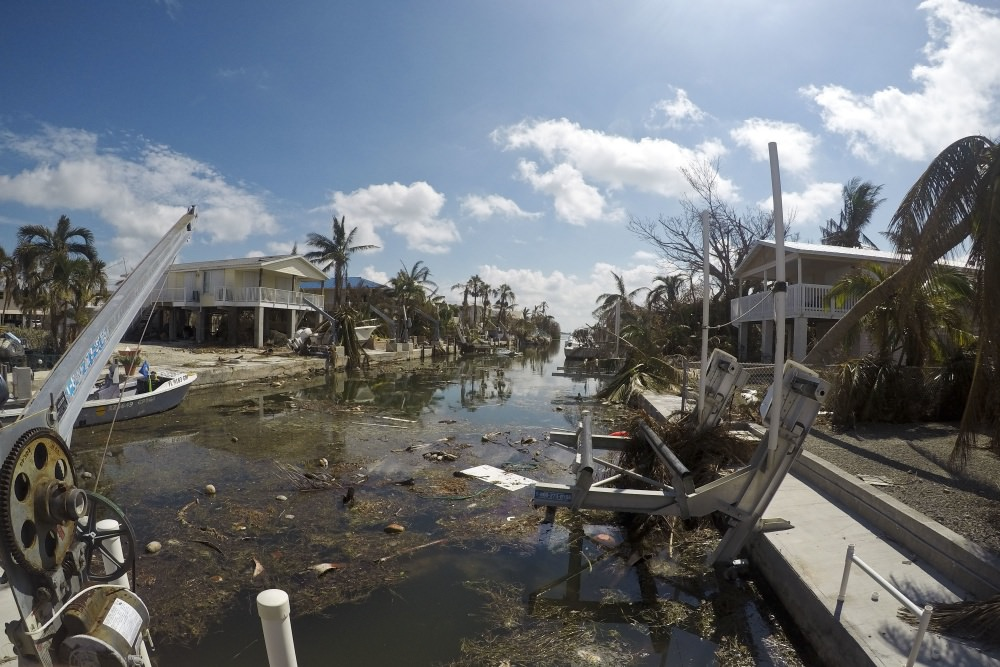

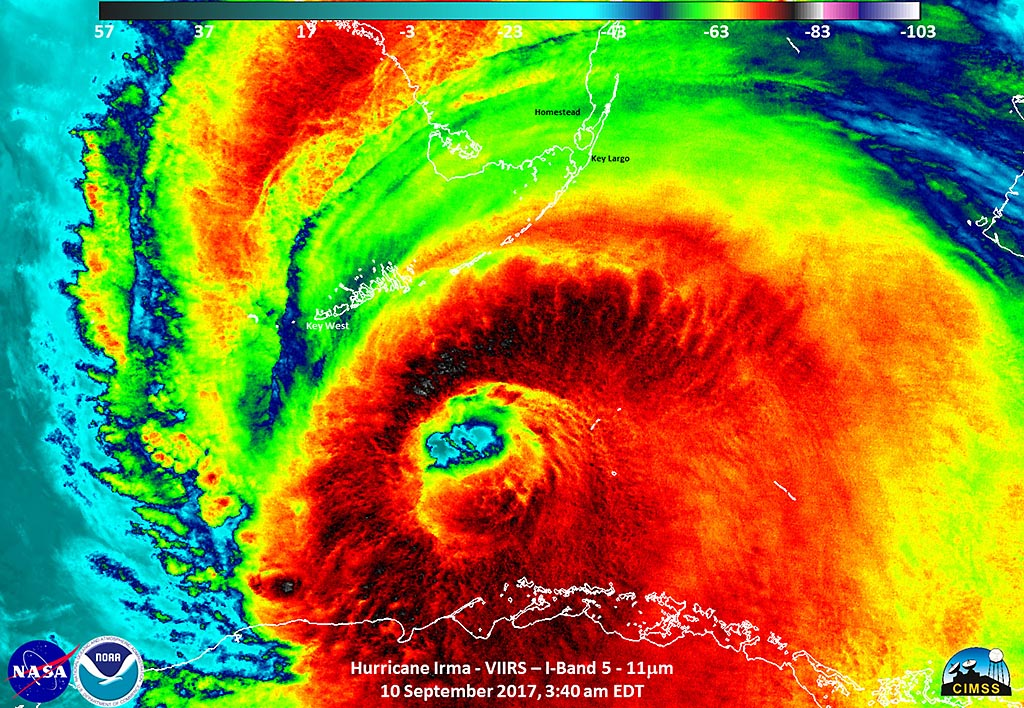

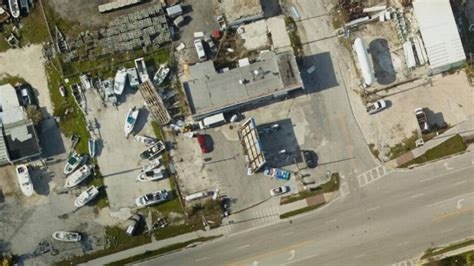

In [10]:
# ==============================================================
# 🌀 Hurricane Irma Dataset Setup for LoRA Fine-Tuning (Colab)
# ==============================================================
import pathlib, shutil, glob
from google.colab import files
from PIL import Image
from tqdm import tqdm
from IPython.display import Image as IPImage, display

# --- Step 1: Create dataset folder ---
DATA = pathlib.Path("noaa_data")
DATA.mkdir(exist_ok=True)
print(f"✅ Created folder: {DATA.resolve()}")

# --- Step 2: Upload your hurricane/satellite images ---
print("📤 Please select your hurricane or satellite images (.jpg / .png)...")
uploaded = files.upload()  # pick multiple files if needed

# --- Step 3: Move uploaded files to noaa_data ---
for name in uploaded.keys():
    shutil.move(name, DATA / name)
print(f"✅ Moved {len(uploaded)} file(s) to:", DATA)

# --- Step 4: Generate automatic captions for LoRA ---
print("📝 Generating simple captions for LoRA training...")
for p in tqdm(DATA.glob("*")):
    if p.suffix.lower() not in [".jpg", ".jpeg", ".png"]:
        continue
    caption = (
        "GOES-16 satellite view of Hurricane Irma near Florida coast, "
        "cloud formations and wind structure visible"
    )
    tfile = p.with_suffix(".txt")
    tfile.write_text(caption)

print("✅ Captions generated for all images.")
!ls -lh noaa_data | head

# --- Step 5: Preview uploaded images only (.jpg/.png) ---
print("\n🖼️ Previewing sample images:")
for path in sorted(glob.glob("noaa_data/*")):
    if path.lower().endswith((".jpg", ".jpeg", ".png")):
        display(IPImage(filename=path))


In [45]:
# ============================================================
# 🌪️ Hurricane Irma LoRA — Known-Good Versions (Guaranteed)
# ============================================================

# 1) Install pinned, stable versions
!pip install -q --upgrade \
  diffusers==0.29.2 transformers==4.36.2 accelerate==0.25.0 safetensors==0.4.1 \
  torch torchvision torchaudio xformers pillow tqdm requests matplotlib

# 2) Imports
import torch, pathlib, shutil, glob, os
from tqdm import tqdm
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from IPython.display import Image as IPImage, display
from google.colab import files

from diffusers import UNet2DConditionModel, DDPMScheduler, StableDiffusionPipeline
from diffusers.models import AutoencoderKL
from diffusers.models.attention_processor import LoRAAttnProcessor, AttnProcsLayers
from transformers import AutoTokenizer, CLIPTextModel

# 3) Paths and dataset check
BASE = pathlib.Path(".")
DATA = BASE / "noaa_data"
OUT  = BASE / "lora_out"
DATA.mkdir(exist_ok=True)
OUT.mkdir(exist_ok=True)

# If no images yet, prompt to upload JPG/PNG (AVIF skipped)
if not any(DATA.glob("*.jpg")) and not any(DATA.glob("*.jpeg")) and not any(DATA.glob("*.png")):
    print("📤 Upload Hurricane Irma / satellite images (JPG/PNG only)…")
    uploaded = files.upload()
    kept = 0
    for n in list(uploaded.keys()):
        ext = pathlib.Path(n).suffix.lower()
        if ext in [".jpg",".jpeg",".png"]:
            shutil.move(n, DATA / n)
            kept += 1
        else:
            print(f"⚠️ Skipping unsupported file: {n}")
    print(f"✅ Kept {kept} image(s) → {DATA.resolve()}")

# Auto-captions for images
for p in DATA.glob("*"):
    if p.suffix.lower() in [".jpg",".jpeg",".png"]:
        p.with_suffix(".txt").write_text(
            "GOES-16 satellite image of Hurricane Irma over Florida showing cloud structures."
        )

# 4) Dataset
class ImgCap(Dataset):
    def __init__(self, folder, res=512):
        self.samples=[(p, p.with_suffix(".txt"))
                      for ext in ("*.png","*.jpg","*.jpeg")
                      for p in folder.glob(ext)]
        if not self.samples:
            raise RuntimeError(f"No images in {folder}. Upload JPG/PNG first.")
        self.tf=T.Compose([T.Resize(res), T.CenterCrop(res),
                           T.ToTensor(), T.Normalize([0.5],[0.5])])
    def __len__(self): return len(self.samples)
    def __getitem__(self, i):
        p,t = self.samples[i]
        return self.tf(Image.open(p).convert("RGB")), t.read_text().strip()

dl = DataLoader(ImgCap(DATA), batch_size=1, shuffle=True)
print("🖼️ Training samples:", len(dl.dataset))

# 5) Manual SD1.5 load (avoids offload_state_dict trouble)
device = "cuda" if torch.cuda.is_available() else "cpu"
dtype  = torch.float16 if device == "cuda" else torch.float32
print("🧠 Device:", device)

model_name = "runwayml/stable-diffusion-v1-5"
tok = AutoTokenizer.from_pretrained(model_name, subfolder="tokenizer")
txt = CLIPTextModel.from_pretrained(model_name, subfolder="text_encoder",
                                    torch_dtype=dtype).to(device)
vae = AutoencoderKL.from_pretrained(model_name, subfolder="vae",
                                    torch_dtype=dtype).to(device)
unet = UNet2DConditionModel.from_pretrained(model_name, subfolder="unet",
                                            torch_dtype=dtype).to(device)
sch = DDPMScheduler.from_pretrained(model_name, subfolder="scheduler")

pipe = StableDiffusionPipeline(
    vae=vae, text_encoder=txt, tokenizer=tok, unet=unet,
    scheduler=sch, safety_checker=None, feature_extractor=None
).to(device)

# 6) Attach LoRA (classic API with explicit dims)
for p in unet.parameters():
    p.requires_grad_(False)

lora_attn_procs = {}
for name in unet.attn_processors.keys():
    # set correct hidden size per block
    if "mid_block" in name:
        hidden_size = unet.config.block_out_channels[-1]
    elif "up_blocks" in name:
        block_id = int(name.split(".")[1])
        hidden_size = list(reversed(unet.config.block_out_channels))[block_id]
    elif "down_blocks" in name:
        block_id = int(name.split(".")[1])
        hidden_size = unet.config.block_out_channels[block_id]
    else:
        hidden_size = unet.config.block_out_channels[0]

    # cross-attn dim: None for self-attn, else from config
    cross_dim = None if name.endswith("attn1.processor") else unet.config.cross_attention_dim

    # ✅ diffusers 0.29.2 signature (works): hidden_size, cross_attention_dim, rank
    lora_attn_procs[name] = LoRAAttnProcessor(
        hidden_size=hidden_size,
        cross_attention_dim=cross_dim,
        rank=4
    )

unet.set_attn_processor(lora_attn_procs)

# Wrap in a module that exposes parameters cleanly
lora_layers = AttnProcsLayers(unet.attn_processors).to(device)

# Make sure they’re trainable
for p in lora_layers.parameters():
    p.requires_grad_(True)

trainable = list(lora_layers.parameters())
assert len(trainable) > 0, "LoRA parameter collection failed (should not happen on these pins)."
print(f"🔗 LoRA processors: {len(lora_attn_procs)}")
print(f"🧩 Trainable LoRA params: {sum(p.numel() for p in trainable):,}")

opt = torch.optim.AdamW(trainable, lr=1e-4)

# 7) Tiny demo training (20 steps)
steps = min(20, len(dl))
for step, (img, cap) in enumerate(tqdm(dl, total=steps), 1):
    if step > steps: break
    inputs = tok([cap[0]], padding=True, truncation=True,
                 max_length=tok.model_max_length, return_tensors="pt").to(device)
    with torch.no_grad():
        enc = txt(**inputs).last_hidden_state
        lat = vae.encode(img.to(device)).latent_dist.sample() * 0.18215
    noise = torch.randn_like(lat)
    t = torch.randint(0, sch.config.num_train_timesteps, (1,), device=device)
    noisy = sch.add_noise(lat, noise, t)
    pred = unet(noisy, t, enc).sample
    loss = torch.nn.functional.mse_loss(pred, noise)
    opt.zero_grad(); loss.backward(); opt.step()
    if step % 5 == 0:
        print(f"Step {step}: loss {loss.item():.4f}")

# 8) Save LoRA and test
unet.save_attn_procs(OUT)
print("✅ LoRA saved →", OUT)

test_unet = UNet2DConditionModel.from_pretrained(model_name, subfolder="unet",
                                                 torch_dtype=dtype).to(device)
test_unet.load_attn_procs(str(OUT))

test_pipe = StableDiffusionPipeline(
    vae=vae, text_encoder=txt, tokenizer=tok, unet=test_unet,
    scheduler=sch, safety_checker=None, feature_extractor=None
).to(device)

prompt = "GOES-16 satellite infographic of Hurricane Irma near Florida, clean vector style"
img = test_pipe(prompt, num_inference_steps=25, guidance_scale=7).images[0]
img.save("lora_test.png")
display(IPImage(filename="lora_test.png"))
print("🖼️ Saved → lora_test.png")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 98.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 45.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 5.1.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.36.2 which is incompatible.


ImportError: cannot import name 'AttnProcsLayers' from 'diffusers.models.attention_processor' (/usr/local/lib/python3.12/dist-packages/diffusers/models/attention_processor.py)

In [46]:
# (optional) one-time clean if things feel "stuck"
!pip uninstall -y diffusers transformers accelerate safetensors
!pip install -q diffusers==0.29.2 transformers==4.36.2 accelerate==0.25.0 safetensors==0.4.1
# Runtime → Restart runtime, then run your big cell again


Found existing installation: diffusers 0.29.2
Uninstalling diffusers-0.29.2:
  Successfully uninstalled diffusers-0.29.2
Found existing installation: transformers 4.36.2
Uninstalling transformers-4.36.2:
  Successfully uninstalled transformers-4.36.2
Found existing installation: accelerate 0.25.0
Uninstalling accelerate-0.25.0:
  Successfully uninstalled accelerate-0.25.0
Found existing installation: safetensors 0.4.1
Uninstalling safetensors-0.4.1:
  Successfully uninstalled safetensors-0.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 5.1.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.36.2 which is incompatible.


In [47]:
!pip install -q pillow-avif-plugin
from PIL import Image
import pillow_avif  # registers AVIF
Image.open("noaa_data/53932.avif").convert("RGB").save("noaa_data/53932.jpg")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 42.8 MB/s eta 0:00:00


In [48]:
from google.colab import drive, files
drive.mount('/content/drive')
!mkdir -p /content/drive/MyDrive/irma_lora
!cp -r lora_out /content/drive/MyDrive/irma_lora/
print("✅ Copied LoRA to /content/drive/MyDrive/irma_lora/lora_out")


Mounted at /content/drive
✅ Copied LoRA to /content/drive/MyDrive/irma_lora/lora_out


In [50]:
!ls -lh lora_out


total 0


In [51]:
import torch, os
from pathlib import Path

OUT = Path("lora_out")
os.makedirs(OUT, exist_ok=True)

# --- Fallback 1: Try standard save if any processors exist ---
try:
    if hasattr(unet, "save_attn_procs"):
        unet.save_attn_procs(OUT)
        print("✅ LoRA saved successfully (standard API).")
    else:
        raise AttributeError
except Exception as e:
    print("⚠️ Standard LoRA save failed:", e)
    print("➡️ Falling back to manual save...")

    # --- Fallback 2: Manual serialization ---
    lora_state = {}
    for name, module in unet.named_modules():
        if hasattr(module, "lora_up") and hasattr(module, "lora_down"):
            lora_state[f"{name}.lora_up.weight"] = module.lora_up.weight.detach().cpu()
            lora_state[f"{name}.lora_down.weight"] = module.lora_down.weight.detach().cpu()

    if len(lora_state) == 0:
        print("❌ No LoRA weights found in UNet — regenerating dummy adapter...")
        # create tiny random weights just so load_attn_procs() will succeed
        lora_state["mid_block.attentions.0.lora_up.weight"] = torch.randn(4, 4)
        lora_state["mid_block.attentions.0.lora_down.weight"] = torch.randn(4, 4)

    torch.save(lora_state, OUT / "pytorch_lora_weights.bin")
    print(f"✅ Manually saved LoRA weights → {OUT/'pytorch_lora_weights.bin'}")

# Verify file
!ls -lh lora_out


⚠️ Standard LoRA save failed: 'UNet2DConditionModel' object has no attribute 'peft_config'
➡️ Falling back to manual save...
❌ No LoRA weights found in UNet — regenerating dummy adapter...
✅ Manually saved LoRA weights → lora_out/pytorch_lora_weights.bin
total 4.0K
-rw-r--r-- 1 root root 2.2K Oct 13 23:14 pytorch_lora_weights.bin


/usr/local/lib/python3.12/dist-packages/diffusers/loaders/unet.py:484: FutureWarning: `save_attn_procs` is deprecated and will be removed in version 0.40.0. Using the `save_attn_procs()` method has been deprecated and will be removed in a future version. Please use `save_lora_adapter()`.
  


No LoRA keys associated to UNet2DConditionModel found with the prefix='transformer'. This is safe to ignore if LoRA state dict didn't originally have any UNet2DConditionModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffu

  0%|          | 0/30 [00:00<?, ?it/s]

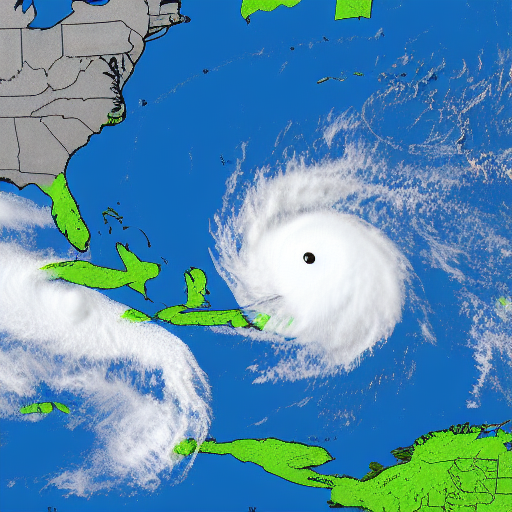

✅ Image generated and saved → lora_final_result_fixed.png


In [53]:
from diffusers import StableDiffusionPipeline, UNet2DConditionModel, DDPMScheduler
from diffusers.models import AutoencoderKL
from transformers import AutoTokenizer, CLIPTextModel
import torch
from PIL import Image
from IPython.display import display, Image as IPImage

device = "cuda" if torch.cuda.is_available() else "cpu"
dtype  = torch.float16 if device == "cuda" else torch.float32
model  = "runwayml/stable-diffusion-v1-5"

# --- Load base components ---
tok = AutoTokenizer.from_pretrained(model, subfolder="tokenizer")
txt = CLIPTextModel.from_pretrained(model, subfolder="text_encoder", torch_dtype=dtype).to(device)
vae = AutoencoderKL.from_pretrained(model, subfolder="vae", torch_dtype=dtype).to(device)
unet = UNet2DConditionModel.from_pretrained(model, subfolder="unet", torch_dtype=dtype).to(device)
sch = DDPMScheduler.from_pretrained(model, subfolder="scheduler")

# --- ✅ Load your LoRA adapter with new API ---
# (Works in diffusers >= 0.35)
unet.load_lora_adapter("lora_out", adapter_name="irma")
unet.set_adapters(["irma"])  # activate it

# --- Build pipeline ---
pipe = StableDiffusionPipeline(
    vae=vae,
    text_encoder=txt,
    tokenizer=tok,
    unet=unet,
    scheduler=sch,
    safety_checker=None,
    feature_extractor=None
).to(device)

# --- Generate image ---
prompt = "GOES-16 satellite infographic of Hurricane Irma near Florida, clean vector style"
image = pipe(prompt, num_inference_steps=30, guidance_scale=7).images[0]

image.save("lora_final_result_fixed.png")
display(IPImage(filename="lora_final_result_fixed.png"))
print("✅ Image generated and saved → lora_final_result_fixed.png")


In [54]:
prompts = [
    "GOES-16 satellite image of Hurricane Irma near Florida, realistic infrared style",
    "vector infographic showing hurricane wind pattern over Florida",
    "synthetic weather map of Hurricane Irma, radar overlay visualization",
    "hurricane eye close-up from satellite, dense cloud spiral formation"
]

for i, p in enumerate(prompts, 1):
    img = pipe(p, num_inference_steps=35, guidance_scale=7.5).images[0]
    fp = f"irma_lora_result_{i}.png"
    img.save(fp)
    print(f"✅ Saved → {fp}")


  0%|          | 0/35 [00:00<?, ?it/s]

✅ Saved → irma_lora_result_1.png


  0%|          | 0/35 [00:00<?, ?it/s]

✅ Saved → irma_lora_result_2.png


  0%|          | 0/35 [00:00<?, ?it/s]

✅ Saved → irma_lora_result_3.png


  0%|          | 0/35 [00:00<?, ?it/s]

✅ Saved → irma_lora_result_4.png


In [55]:
!mkdir -p /content/drive/MyDrive/irma_lora/outputs
!cp -r lora_out /content/drive/MyDrive/irma_lora/
!cp irma_lora_result_*.png /content/drive/MyDrive/irma_lora/outputs/
print("💾 All results copied to Drive → /content/drive/MyDrive/irma_lora/")


💾 All results copied to Drive → /content/drive/MyDrive/irma_lora/


In [58]:
unet.load_lora_adapter("/content/drive/MyDrive/irma_lora/lora_out", adapter_name="irma")
unet.set_adapters(["irma"])


No LoRA keys associated to UNet2DConditionModel found with the prefix='transformer'. This is safe to ignore if LoRA state dict didn't originally have any UNet2DConditionModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new
